# CLI vs Python API Comparison

This notebook compares the output of the original Fortran CLI (`hv_orig`) and the Python API (`hvswdpy`) for computing H/V spectral ratios and dispersion curves.

It will:
- Read the layered model from `model.txt`
- Run the CLI to generate HV and dispersion data
- Use the Python API to compute the same quantities
- Compare and visualize the results
- Save comparison plots to the `results/` directory


In [1]:
# Setup and imports
import os
import sys
import subprocess
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    SCRIPT_DIR = Path.cwd().resolve()
ROOT = SCRIPT_DIR.parent

# Import hvswdpy
try:
    import hvswdpy as hv  
except ModuleNotFoundError:
    sys.path.insert(0, str(ROOT / 'src'))
    import hvswdpy as hv

print(f"Working directory: {SCRIPT_DIR}")
print(f"Root directory: {ROOT}")

Working directory: /Users/shihao/Research/Codes/SWD-HV-DFA/examples
Root directory: /Users/shihao/Research/Codes/SWD-HV-DFA


## Helper Functions

Define functions for reading model files, running the CLI, and reading CLI output files.


In [2]:
def read_model(path):
    with open(path, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    n = int(lines[0])
    vp = []
    vs = []
    rho = []
    th = []
    for i in range(1, n + 1):
        t, a, b, d = lines[i].split()
        if i < n:
            th.append(float(t))
        vp.append(float(a))
        vs.append(float(b))
        rho.append(float(d))
    return (np.array(vp, dtype=np.float64),
            np.array(vs, dtype=np.float64),
            np.array(rho, dtype=np.float64),
            np.array(th, dtype=np.float64))


def run_cli(model_file, nf=100, fmin=0.1, fmax=100.0, nmr=3, nml=3, prec=1.0, nks=0):
    hv_orig = ROOT / 'bin' / 'hv_orig'
    cmd = [
        str(hv_orig),
        '-f', str(model_file),
        '-fmin', str(fmin),
        '-fmax', str(fmax),
        '-nf', str(nf),
        '-logsam',
        '-nmr', str(nmr),
        '-nml', str(nml),
        '-prec', str(prec),
        '-nks', str(nks),
        '-ph',
        '-hv',
    ]
    with open(SCRIPT_DIR / 'HV.dat', 'w') as hv_out:
        res = subprocess.run(cmd, cwd=str(SCRIPT_DIR), stdout=hv_out, stderr=subprocess.PIPE, text=True)
    if res.returncode != 0:
        raise RuntimeError(f"CLI failed: {res.stderr}")
    if not (SCRIPT_DIR / 'Rph.dat').exists():
        raise FileNotFoundError('Rph.dat was not created')
    if not (SCRIPT_DIR / 'HV.dat').exists():
        raise FileNotFoundError('HV.dat was not created (stdout redirection)')


def read_cli_hv(path=SCRIPT_DIR / 'HV.dat'):
    arr = np.fromstring(open(path, 'r').read(), sep=' ')
    if arr.size % 2 != 0:
        raise ValueError('Unexpected HV.dat format')
    pairs = arr.reshape(-1, 2)
    return pairs[:, 0], pairs[:, 1]


def read_cli_dispersion(path):
    # Reads Rph.dat or Lph.dat
    with open(path, 'r') as f:
        content = f.read().strip().split()
    nf = int(content[0]); nm = int(content[1])
    sl = np.array(list(map(float, content[2:2 + nf * nm])))
    flags_raw = content[2 + nf * nm: 2 + nf * nm + nf * nm]
    valid = np.array([tok == 'T' for tok in flags_raw])
    sl = sl.reshape(nm, nf)
    valid = valid.reshape(nm, nf)
    return sl, valid


## Configuration and Model Loading

Set up computation parameters and load the layered model.


In [3]:
# Computation parameters
model_file = SCRIPT_DIR / 'model.txt'
nf = 100
fmin, fmax = 0.1, 50.0
nmr, nml = 5, 5
prec = 0.1
nks = 0

results_dir = SCRIPT_DIR / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

# Read model
vp, vs, rho, th = read_model(model_file)
print(f"Model loaded: {len(vp)} layers")
print(f"Frequency range: {fmin} - {fmax} Hz ({nf} points)")
print(f"Rayleigh modes: {nmr}, Love modes: {nml}")

freq = np.logspace(np.log10(fmin), np.log10(fmax), nf)


Model loaded: 2 layers
Frequency range: 0.1 - 50.0 Hz (100 points)
Rayleigh modes: 5, Love modes: 5


## Run CLI Computation

Execute the Fortran CLI to generate HV and dispersion data.


In [4]:
# Run CLI
print("Running CLI...")
run_cli(model_file, nf=nf, fmin=fmin, fmax=fmax, nmr=nmr, nml=nml, prec=prec, nks=nks)

# Read CLI results
f_cli, hv_cli = read_cli_hv(SCRIPT_DIR / 'HV.dat')
r_sl_cli, r_va_cli = read_cli_dispersion(SCRIPT_DIR / 'Rph.dat')

# Check for Love wave data
l_sl_cli, l_va_cli = (None, None)
if (SCRIPT_DIR / 'Lph.dat').exists():
    l_sl_cli, l_va_cli = read_cli_dispersion(SCRIPT_DIR / 'Lph.dat')
    print("Love wave data found")
else:
    print("No Love wave data")

print(f"CLI HV data: {len(f_cli)} frequency points")
print(f"CLI Rayleigh data: {r_sl_cli.shape[0]} modes, {r_sl_cli.shape[1]} frequencies")


Running CLI...
Love wave data found
CLI HV data: 100 frequency points
CLI Rayleigh data: 5 modes, 100 frequencies


## Run Python API Computation

Use the Python API to compute the same quantities.


In [5]:
# Compute HV using Python API
hv_py, status_hv = hv.hv(
    frequencies_hz=freq,
    vp=vp, vs=vs, rho=rho, thickness=th,
    n_rayleigh_modes=nmr, n_love_modes=nml, precision_percent=prec, nks=nks)

# Compute dispersion using Python API
disp = hv.dispersion(
    frequencies_hz=freq,
    vp=vp, vs=vs, rho=rho, thickness=th,
    n_rayleigh_modes=nmr, n_love_modes=nml, precision_percent=prec)

r_sl_py = disp.rayleigh_slowness
r_va_py = disp.rayleigh_valid
l_sl_py = disp.love_slowness
l_va_py = disp.love_valid
status_dp = disp.status

print(f"Python API HV data: {len(hv_py)} frequency points")
print(f"Python API Rayleigh data: {r_sl_py.shape[1]} modes, {r_sl_py.shape[0]} frequencies")


Python API HV data: 100 frequency points
Python API Rayleigh data: 5 modes, 100 frequencies


## Plot H/V Comparison

Compare the H/V spectral ratios computed by CLI and Python API.


Saved HV plot: /Users/shihao/Research/Codes/SWD-HV-DFA/examples/results/compare_hv.png


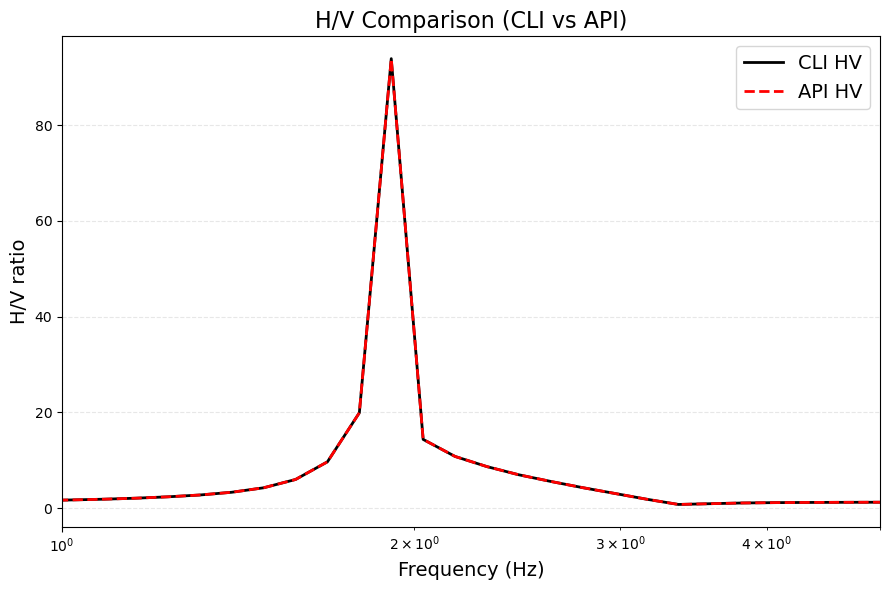

In [16]:
# Interpolate if frequency vectors differ
if not np.allclose(f_cli, freq):
    hv_py_plot = np.interp(f_cli, freq, hv_py)
    f_plot = f_cli
else:
    hv_py_plot = hv_py
    f_plot = freq

plt.figure(figsize=(9, 6))
plt.semilogx(f_cli, hv_cli, 'k-', lw=2, label='CLI HV')
plt.semilogx(f_plot, hv_py_plot, 'r--', lw=2, label='API HV')
plt.xlim(1, 5)
plt.xlabel('Frequency (Hz)',fontsize=14)
plt.ylabel('H/V ratio',fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=14)
plt.title('H/V Comparison (CLI vs API)',fontsize=16)
plt.tight_layout()

hv_png = results_dir / 'compare_hv.png'
plt.savefig(str(hv_png), dpi=300)
print(f"Saved HV plot: {hv_png}")
plt.show()


## Plot Rayleigh Dispersion Comparison

Compare the Rayleigh wave dispersion curves computed by CLI and Python API.


Saved Rayleigh dispersion plot: /Users/shihao/Research/Codes/SWD-HV-DFA/examples/results/compare_rayleigh_dispersion.png


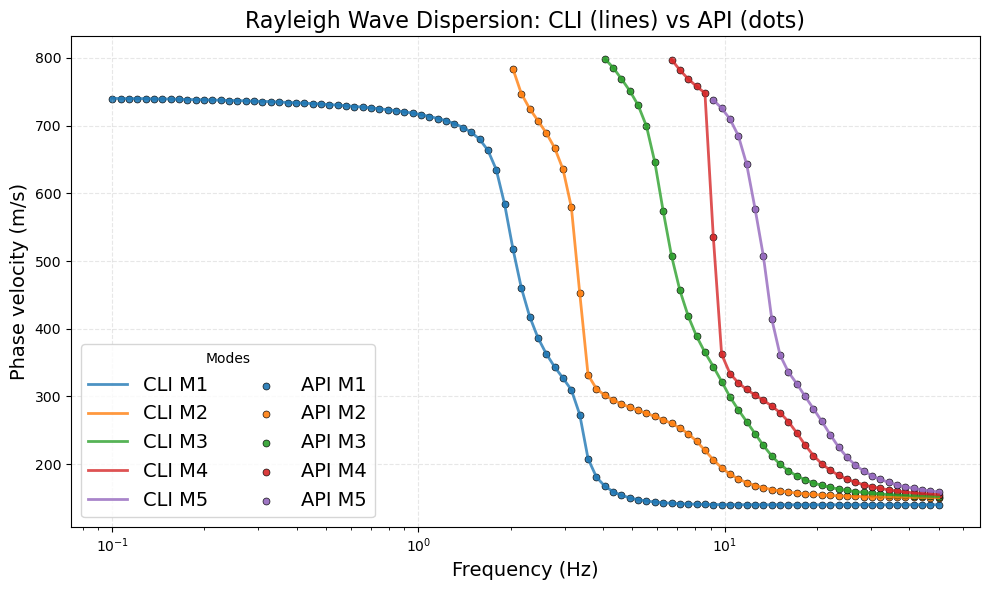

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = ['C0', 'C1', 'C2', 'C3', 'C4']
nm_ray = r_sl_cli.shape[0]

# Plot CLI data
for im in range(nm_ray):
    mask = r_va_cli[im]
    vel_cli = 1.0 / r_sl_cli[im, mask]
    ax.plot(f_cli[mask], vel_cli, color=colors[im % len(colors)], 
            linewidth=2, alpha=0.8, label=f'CLI M{im+1}' if im < 5 else "")

# Plot API data
nm_ray_py = r_sl_py.shape[1]
for im in range(nm_ray_py):
    mask = (r_va_py[:, im] != 0)
    vel_py = 1.0 / r_sl_py[mask, im]
    ax.scatter(freq[mask], vel_py, s=25, color=colors[im % len(colors)], 
               marker='o', alpha=0.9, edgecolors='black', linewidth=0.5,
               label=f'API M{im+1}' if im < 5 else "")

ax.set_xscale('log')
ax.set_xlabel('Frequency (Hz)',fontsize=14)
ax.set_ylabel('Phase velocity (m/s)',fontsize=14)
ax.set_title('Rayleigh Wave Dispersion: CLI (lines) vs API (dots)',fontsize=16)
ax.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(handles[:10], labels[:10], title='Modes', fontsize=14, ncol=2)

plt.tight_layout()
ray_png = results_dir / 'compare_rayleigh_dispersion.png'
plt.savefig(str(ray_png), dpi=300)
print(f"Saved Rayleigh dispersion plot: {ray_png}")
plt.show()


## Plot Love Dispersion Comparison (if available)

Compare the Love wave dispersion curves if they were computed.


Saved Love dispersion plot: /Users/shihao/Research/Codes/SWD-HV-DFA/examples/results/compare_love_dispersion.png


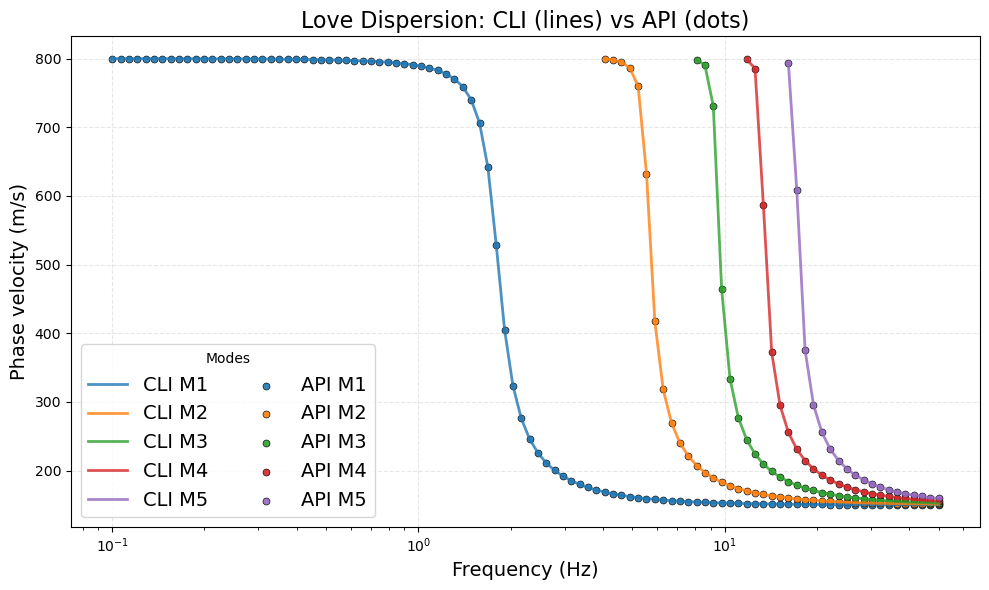

In [ ]:
if l_sl_cli is not None:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    nm_lov = l_sl_cli.shape[0]
    # Plot CLI data
    for im in range(nm_lov):
        mask = l_va_cli[im]
        vel_cli = 1.0 / l_sl_cli[im, mask]
        ax.plot(f_cli[mask], vel_cli, color=colors[im % len(colors)], 
                linewidth=2, alpha=0.8, label=f'CLI M{im+1}' if im < 5 else "")

    nm_lov_py = l_sl_py.shape[1]
    # Plot API data
    for im in range(nm_lov_py):
        mask = (l_va_py[:, im] != 0)
        vel_py = 1.0 / l_sl_py[mask, im]
        ax.scatter(freq[mask], vel_py, s=25, color=colors[im % len(colors)], 
                   marker='o', alpha=0.9, edgecolors='black', linewidth=0.5,
                   label=f'API M{im+1}' if im < 5 else "")

    ax.set_xscale('log')
    ax.set_xlabel('Frequency (Hz)',fontsize=14)
    ax.set_ylabel('Phase velocity (m/s)',fontsize=14)
    ax.set_title('Love Wave Dispersion: CLI (lines) vs API (dots)',fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles[:10], labels[:10], title='Modes', fontsize=14, ncol=2)

    plt.tight_layout()
    lov_png = results_dir / 'compare_love_dispersion.png'
    plt.savefig(str(lov_png), dpi=150)
    print(f"Saved Love dispersion plot: {lov_png}")
    plt.show()
else:
    print("No Love wave data available for plotting")
    lov_png = None
